# TOXIC TWEETS ANALYSIS (SPANISH)
Transformers-based finetuning of a multilingual `XLM-Roberta` model, with GridSearch on the Hyperparameters tuning with `optuna` and interpretability with `shap`

## GPU specs

In [ ]:
!nvidia-smi

Thu May 25 15:12:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/toxicity_test_data.csv

In [ ]:
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/toxicity_train_data.csv

In [ ]:
%pip install transformers xformers datasets accelerate optuna shap

## Auxiliar cleaning text functions
In the evaluation process I saw the model was learning from meaningless urls. I decided to clean them (besides some other noisy symbols)

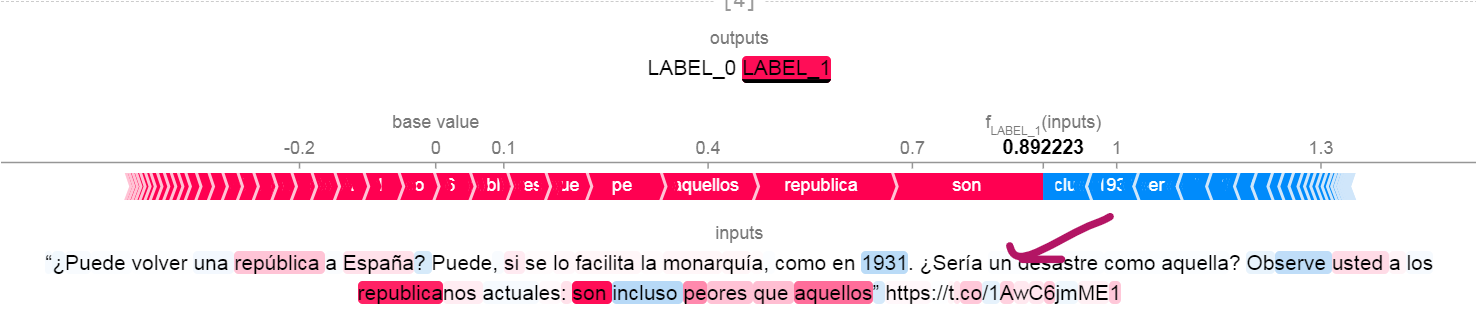

In [ ]:
import re
def clean(text):
    text = re.sub(r'http\S+', '', text)
    text = text.replace('#','').replace('@','')
    text = text.replace("  ", " ").strip()
    return text

In [ ]:
RANDOM_STATE = 42 # 42

In [ ]:
import datasets
import random
import pandas as pd
from datasets import Dataset

## Analysis of Training Data
- The labels are inbalanced, where number of `toxic` comments is much less than `not_toxic`
- Almost all `news_articles` are not toxic, so the model may pick up that as a signal
- If we filter by `twitter`, data are balanced
- Twitter data has some noise, as shorten urls, which add noise (we will clean them).
- Twitter data has some emojis, which have meaning as any other symbol. We don't clean them.

In [ ]:
train_df = pd.read_csv('toxicity_train_data.csv').sample(frac=1.0, random_state=RANDOM_STATE, replace=False)
train_df['text'] = train_df['text'].apply(clean)

train_df

id  \
107                               1.272409168486568e+18   
5484                             1.2184687175684465e+18   
6998                             1.2808908312731116e+18   
3984                             1.2234129085933814e+18   
3111  https://www.elplural.com/opinion/hable-mayoria...   
...                                                 ...   
5734                             1.3613316221681254e+18   
5191  http://www.vanitatis.elconfidencial.com/casas-...   
5390                             1.2761723033872876e+18   
860   https://www.elespanol.com/el-cultural/letras/2...   
7270                              1.232356203075973e+18   

                                                   text  label         origin  \
107   Luis M. Ansón: "En el entorno de Pedro Sánchez...      0        twitter   
5484  El debate sobre la censura educativa (PIN pare...      0        twitter   
6998  Vamos a escándalo diario. España merece más qu...      0        twitter   
3984  1/ La siniestra se ha puesto ahora como objeti...      1        twitter   
3111  Iglesias, que ya había anunciado su intención ...      0  news-articles   
...                                                 ...    ...            ...   
5734  Rosa María Mateo tendrá que explicar por qué a...      1        twitter   
5191        ¿Tienes un dispositivo móvil iOS o Android?      0  news-articles   
5390  ‍♂️ «Es decepcionante que se vuelva a aparcar ...      0        twitter   
860   Entre los del presente más inmediato, encontra...      0  news-articles   
7270  Aquí tenemos a los que espían a los alumnos en...      1        twitter   

        id-type  
107   twitterId  
5484  twitterId  
6998  twitterId  
3984  twitterId  
3111        url  
...         ...  
5734  twitterId  
5191        url  
5390  twitterId  
860         url  
7270  twitterId  

[11000 rows x 5 columns]

<AxesSubplot:xlabel='origin'>

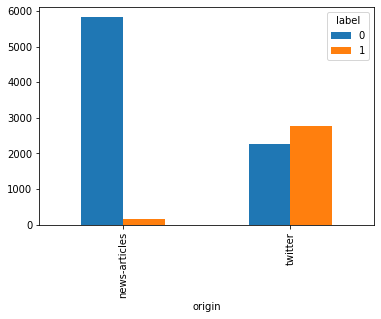

In [ ]:
train_df.groupby(['origin', 'label']).size().unstack(fill_value=0).plot.bar()

<AxesSubplot:xlabel='label'>

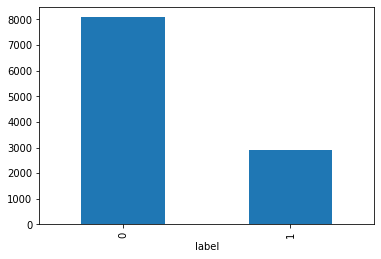

In [ ]:
train_df.groupby(['label']).size().plot.bar()

## I will add more data to balance and fix 2 issues...
So the `toxic` class is imbalanced compared to the `not_toxic`. Also, there are almost **no toxic data among news**, it's mostly present in **tweets**.

To fix a little this issues, without drastically altering the distribution, I will add more **toxic news**

You can't download the data with `wget` since it requires login.

https://app.surgehq.ai/datasets/spanish-toxicity

In [ ]:
import pandas as pd
spanish_toxicity = pd.read_csv('spanish_toxicity.csv')

In [ ]:
spanish_toxicity

worker_id                               task_id  \
0    Z6J69GNZYEXY  2376f671-e15c-4c92-9a27-0d7a6bd6a907   
1    Z6J69GNZYEXY  76b3e3cb-5634-47fd-b5dc-e5bb691584e0   
2    FR7WMH3MFPEE  889f98a0-d5dd-4439-a802-bdf1080133df   
3    Z6J69GNZYEXY  2960a381-e965-4026-9458-ba5d8c85964c   
4    Z6J69GNZYEXY  31ff6f0f-bbde-4415-b5c5-35c4ee6547de   
..            ...                                   ...   
995  Z6J69GNZYEXY  7725423c-c7f2-45d2-8d62-b06d5f42b194   
996  FR7WMH3MFPEE  4cafabbe-dc5b-44c1-bd2a-3fc9a2e72211   
997  Z6J69GNZYEXY  ce72bb63-6296-401f-acbb-fac56d433e49   
998  FR7WMH3MFPEE  8f147c2f-0db8-45ca-a1a3-db5d29612eda   
999  AWEDDH43CFW4  a358ae54-acfe-44ed-93a5-9f1e11977798   

                         task_response_id  \
0    2bfcf1ac-396c-46a9-89cf-bf6eb9326b24   
1    b572fe11-108e-4572-ab06-e9792e400adc   
2    68b997d4-7c38-4c0a-9eb8-d32848ecccf8   
3    383b2b12-cf35-46e5-aa36-6edda069a731   
4    6d85c7e7-5510-410b-94b9-ac1f6e0d6a79   
..                                    ...   
995  dd1a0f19-6c85-44f0-835c-9d3fd3532172   
996  05ee4138-6095-4e26-8820-1d941f5d3661   
997  9182bbb3-0719-4a08-8fc9-d7158341b150   
998  96c447a6-ac37-47e8-94a3-0770824c5f52   
999  6a239466-9312-4b3f-9b21-9c101cd3cc40   

                                          Message Text Toxic/Not Toxic  
0                            Visita la mia storia ora.       Not Toxic  
1    Y la 4ta es la de la final del Open de Austral...       Not Toxic  
2                                  Es un ser superior!       Not Toxic  
3    El Monumento de los Fundadores de Puebla, fue ...       Not Toxic  
4    Hagamos consciencia no tires envolturas, bolsa...       Not Toxic  
..                                                 ...             ...  
995  los religiosos son estupidos no saben nada de ...           Toxic  
996  Callen a Niembro por favor. No lo soporto más,...           Toxic  
997  ese gato solo sirve para matarlo y ponerlo en ...           Toxic  
998  Sisi un visionario el tío. Y usted imbécil ler...           Toxic  
999                     te ves bien perra con esa ropa           Toxic  

[1000 rows x 5 columns]

In [ ]:
spanish_toxicity_toxic = spanish_toxicity[spanish_toxicity['Toxic/Not Toxic']=='Toxic'][['Message Text', 'Toxic/Not Toxic']]
spanish_toxicity_toxic = spanish_toxicity_toxic.rename(columns={'Message Text': 'text', 'Toxic/Not Toxic': 'label'})
spanish_toxicity_toxic['label'] = 1
spanish_toxicity_toxic['text'] = spanish_toxicity_toxic['text'].apply(clean)
spanish_toxicity_toxic

text  label
500  Y los ERES y los abusos a las niñas de Valenci...      1
501           Hijos de puta les quitaba el puto sueldo      1
502                  asi me gustan de culonas mamasita      1
503  MALDITOS INEPTOS baccredomaticgt NINGUNO DE SU...      1
504         que asco de podemitas... es lo más preciso      1
..                                                 ...    ...
995  los religiosos son estupidos no saben nada de ...      1
996  Callen a Niembro por favor. No lo soporto más,...      1
997  ese gato solo sirve para matarlo y ponerlo en ...      1
998  Sisi un visionario el tío. Y usted imbécil ler...      1
999                     te ves bien perra con esa ropa      1

[500 rows x 2 columns]

### I merge the original training dataset and the `spanish-toxicity` dataset, only with toxic **news**

In [ ]:
train_df = pd.concat([train_df[['text', 'label']], spanish_toxicity_toxic])
train_df

text  label
107   Luis M. Ansón: "En el entorno de Pedro Sánchez...      0
5484  El debate sobre la censura educativa (PIN pare...      0
6998  Vamos a escándalo diario. España merece más qu...      0
3984  1/ La siniestra se ha puesto ahora como objeti...      1
3111  Iglesias, que ya había anunciado su intención ...      0
...                                                 ...    ...
995   los religiosos son estupidos no saben nada de ...      1
996   Callen a Niembro por favor. No lo soporto más,...      1
997   ese gato solo sirve para matarlo y ponerlo en ...      1
998   Sisi un visionario el tío. Y usted imbécil ler...      1
999                      te ves bien perra con esa ropa      1

[11500 rows x 2 columns]

<AxesSubplot:xlabel='label'>

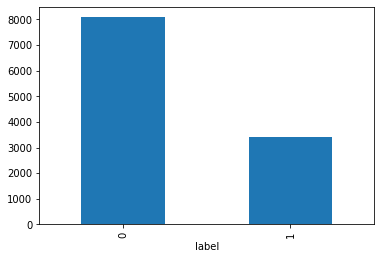

In [ ]:
train_df.groupby(['label']).size().plot.bar()

<AxesSubplot:xlabel='label'>

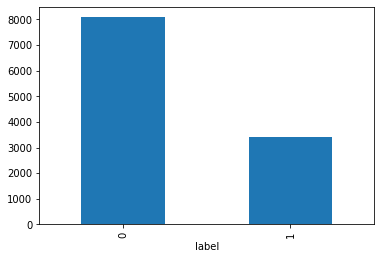

In [ ]:
train_df.groupby(['label']).size().plot.bar()

In [ ]:
train_ds = Dataset.from_pandas(train_df[['text', 'label']])

## Analysis of Test Data
- Similar patterns as in `train`. Which means the split is cohesive and keeps the original distribution of the data.
- However, in this case, `twitter` labels are not so balanced, and `not_toxic` is much more present than `toxic`.

**IMPORTANT** The inbalance in the labels will require us to use metrics which don't only reward the biggest amount of predictions, because that would mean a model can predict always `not_toxic` and still have a good metric because there are very little `toxic` classes in the dataset.

In [ ]:
test_df = pd.read_csv('toxicity_test_data.csv')
test_df['text'] = test_df['text'].apply(clean)

test_df

id  \
0     https://www.newtral.es/voto-internet-eleccione...   
1                                1.4439912260432282e+18   
2     https://maldita.es/feminismo/20230307/laboral-...   
3     https://www.alertadigital.com/2023/03/11/dieci...   
4                                1.3853418377209242e+18   
...                                                 ...   
4995                              1.451427698337849e+18   
4996  https://www.marca.com/futbol/seleccion/2023/03...   
4997                             1.4642168824882217e+18   
4998  https://www.xataka.com/seleccion/este-smartpho...   
4999  https://www.elmundo.es/economia/empresas/2023/...   

                                                   text  label         origin  \
0     El ensayo con los españoles en el extranjero s...      0  news-articles   
1     Hoy a las 20:20 os espero en el programa 24hor...      0        twitter   
2     Además de la diferencia de salarios, hay una s...      0  news-articles   
3     ¿Por qué si se grabó en Gijón, aparece años de...      0  news-articles   
4     Ha sido un placer entregar a jonkortajarena su...      0        twitter   
...                                                 ...    ...            ...   
4995  Hoy me he levantado un poco más temprano para ...      0        twitter   
4996  Y la conclusión del informe es rotunda: "Perte...      0  news-articles   
4997  Cantabria solo avanza de la mano del PSOE y gr...      0        twitter   
4998  Por otro lado, este modelo incorpora un sistem...      0  news-articles   
4999  En los próximos meses se espera la repreciació...      0  news-articles   

        id-type  
0           url  
1     twitterId  
2           url  
3           url  
4     twitterId  
...         ...  
4995  twitterId  
4996        url  
4997  twitterId  
4998        url  
4999        url  

[5000 rows x 5 columns]

<AxesSubplot:xlabel='origin'>

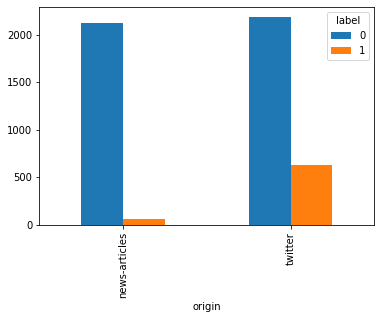

In [ ]:
test_df.groupby(['origin', 'label']).size().unstack(fill_value=0).plot.bar()

<AxesSubplot:xlabel='label'>

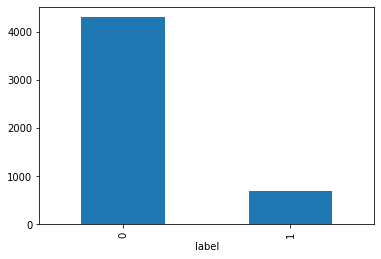

In [ ]:
test_df.groupby(['label']).size().plot.bar()

In [ ]:
test_df.groupby(['label']).size()

label
0    4308
1     692
dtype: int64

In [ ]:
test_ds = Dataset.from_pandas(test_df[['text', 'label']])

## Exploring some random rows

In [ ]:
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(train_ds)

In [ ]:
show_random_elements(test_ds)

## Training with transformers
After checking several architectures, multilingual vs spanish-only and different checkpoints of different models from Hugging Face, the best results seem to be for `XLM Roberta` and `cased`. I will use `based` due to memory restrictions of using `large`.

In [ ]:
model_checkpoint = 'xlm-roberta-base'

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
# Just a test of the tokenizer output
print(test_df['text'].tolist()[0])
tokenizer(test_df['text'].tolist()[0])

El ensayo con los españoles en el extranjero sería la ruta del voto por internet


{'input_ids': [0, 540, 22, 7, 9522, 158, 388, 36131, 90, 22, 88, 148591, 34771, 21, 36344, 146, 48289, 196, 1820, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

## I create my own metrics function
By default, `accuracy` measures the biggest amount of good predictions. However, as we mentioned before, if the classes are imbalanced, it's not the best metric. You could just train a model to predict well the biggest class and get a good accuracy.

We need to penalize the model also using the low represented class. This is better done with `f1` and `roc_auc_score`. I will use `f1`.

In [ ]:
import torch
from torch.nn import functional as F
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def compute_metrics(eval_pred):

    logits, labels = eval_pred
    
    logits_tensor = torch.from_numpy(logits)

    # Apply softmax using torch.softmax
    probabilities_tensor = torch.softmax(logits_tensor, dim=1)

    predictions = torch.argmax(probabilities_tensor, dim=1)
    
    prediction_scores = torch.max(probabilities_tensor, axis=1).values

    return {
        "f1": f1_score(labels, predictions, average="macro"),
        "accuracy": accuracy_score(labels, predictions),
        #"roc_auc": roc_auc_score(labels, torch.max(probabilities_tensor, axis=1).values)
    }

In [ ]:
def preprocess_function(examples):
    # Tokenize examples using the tokenizer
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding=True)

    # Rename the label column if necessary
    if "label" in examples:
        tokenized_inputs["labels"] = examples["label"]

    return tokenized_inputs

In [ ]:
train_ds_proc = train_ds.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [ ]:
test_ds_proc = test_ds.map(preprocess_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

## Hyperparameter search
I will use a Grid (Hyperparameter) search to iterate on different hyperparameters to get the  combination which retrieves the best `f1`.

I will do that with `optuna` library

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

### Grid search with sharding
I create a `shard of 1/10` the data for improving the speed on the GridSearch.

In [ ]:
train_ds_proc_sharded = train_ds_proc.shard(index=1, num_shards=10)

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_ds_proc_sharded,
    eval_dataset=test_ds_proc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# Just to clean previous runs if they were
!rm -Rf xlm-roberta-base-finetuned/* 2> /dev/null

## I start the grid search
- The goal: `maximize F1`
- Tries: 5

**IMPORTANT**: The Grid Search consumes a lot of GPU Memory. You may experience CUDA out of Memory. In that case, reduce the trials.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=5, direction="maximize")

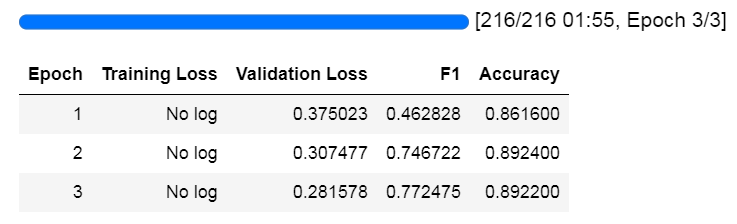

# I train now with the best run but ALL DATA
I used sharding with just a 1/10 of the data.

Now it's time to retrain with that best run hyperparams, but with all the data!

I analyze all the rungs and get the best params. That is usually stored in `best_run`, but I can chose another which is not the best f1 if it looks good also in terms of `accuracy`, `roc_auc` or other metric.

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=7.889038893287002e-06,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    push_to_hub=False,
    seed=37,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds_proc,
    eval_dataset=test_ds_proc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

## As expected, I still got some improvement compared to the shard training

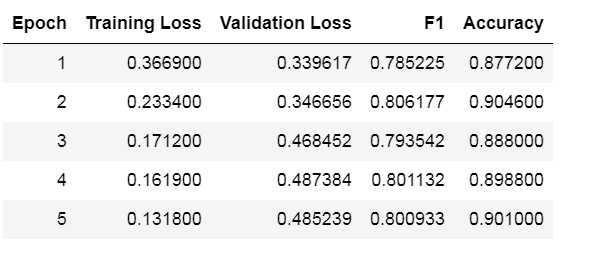

## I save the model

In [ ]:
trainer.save_model("candidate")

Saving model checkpoint to candidate
Configuration saved in candidate/config.json
Model weights saved in candidate/pytorch_model.bin
tokenizer config file saved in candidate/tokenizer_config.json
Special tokens file saved in candidate/special_tokens_map.json


# I infer on test
- To get the prediction labels
- To get the prediction scores
- To put that information in the test_df dataframe
- To analyze the errors (predicted vs expected)
- To analyze the good predictions
- To run SHAP (explainiability)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer.model = trainer.model.to(device)

In [ ]:
import torch
def inference(trainer, input_text):
    input_encoding = tokenizer(input_text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = trainer.model(**input_encoding)
    logits = output.logits
    #logits_tensor = torch.from_numpy(logits)
    probabilities_tensor = torch.softmax(logits, dim=1)
    return probabilities_tensor[0].tolist()

In [ ]:
import tqdm
from torch import tensor

predictions = []
pbar = tqdm.tqdm(total=len(test_ds_proc))

for row in test_ds_proc:
    predictions.append(inference(trainer, row['text']))
    pbar.update(1)
    
pbar.close()

100%|██████████| 5000/5000 [01:32<00:00, 54.31it/s]


In [ ]:
prediction_labels = []
for p in predictions:
    prediction_labels.append(torch.argmax(tensor([p]), dim=1).item())

In [ ]:
predictions[:5]

[[0.9991063475608826, 0.0008936295052990317],
 [0.9994650483131409, 0.0005349523271434009],
 [0.9993255138397217, 0.0006744578131474555],
 [0.9994136095046997, 0.0005864067352376878],
 [0.9994680285453796, 0.000531991885509342]]

In [ ]:
prediction_labels[:5]

[0, 0, 0, 0, 0]

In [ ]:
test_df['predictions'] = prediction_labels
test_df['prediction_scores'] = predictions
test_df

id  \
0     https://www.newtral.es/voto-internet-eleccione...   
1                                1.4439912260432282e+18   
2     https://maldita.es/feminismo/20230307/laboral-...   
3     https://www.alertadigital.com/2023/03/11/dieci...   
4                                1.3853418377209242e+18   
...                                                 ...   
4995                              1.451427698337849e+18   
4996  https://www.marca.com/futbol/seleccion/2023/03...   
4997                             1.4642168824882217e+18   
4998  https://www.xataka.com/seleccion/este-smartpho...   
4999  https://www.elmundo.es/economia/empresas/2023/...   

                                                   text  label         origin  \
0     El ensayo con los españoles en el extranjero s...      0  news-articles   
1     Hoy a las 20:20 os espero en el programa 24hor...      0        twitter   
2     Además de la diferencia de salarios, hay una s...      0  news-articles   
3     ¿Por qué si se grabó en Gijón, aparece años de...      0  news-articles   
4     Ha sido un placer entregar a jonkortajarena su...      0        twitter   
...                                                 ...    ...            ...   
4995  Hoy me he levantado un poco más temprano para ...      0        twitter   
4996  Y la conclusión del informe es rotunda: "Perte...      0  news-articles   
4997  Cantabria solo avanza de la mano del PSOE y gr...      0        twitter   
4998  Por otro lado, este modelo incorpora un sistem...      0  news-articles   
4999  En los próximos meses se espera la repreciació...      0  news-articles   

        id-type  predictions                            prediction_scores  
0           url            0  [0.9991063475608826, 0.0008936295052990317]  
1     twitterId            0  [0.9994650483131409, 0.0005349523271434009]  
2           url            0  [0.9993255138397217, 0.0006744578131474555]  
3           url            0  [0.9994136095046997, 0.0005864067352376878]  
4     twitterId            0   [0.9994680285453796, 0.000531991885509342]  
...         ...          ...                                          ...  
4995  twitterId            1   [0.005168765317648649, 0.9948312640190125]  
4996        url            0  [0.9994254112243652, 0.0005746490205638111]  
4997  twitterId            0  [0.9993201494216919, 0.0006798473768867552]  
4998        url            0  [0.9994854927062988, 0.0005145143368281424]  
4999        url            0  [0.9993107318878174, 0.0006892278324812651]  

[5000 rows x 7 columns]

### I make sure the results are as calculated in the training process

In [ ]:
import sklearn

sklearn.metrics.accuracy_score(test_df['label'], test_df['predictions'])

0.901

## I push the model to Hugging Face Hub

In [ ]:
trainer.push_to_hub()

Cloning https://huggingface.co/jjmcarrascosa/xlm-roberta-base-finetuned into local empty directory.
Saving model checkpoint to xlm-roberta-base-finetuned
Configuration saved in xlm-roberta-base-finetuned/config.json
Model weights saved in xlm-roberta-base-finetuned/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned/special_tokens_map.json
Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.04G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/2.98k [00:00<?, ?B/s]

To https://huggingface.co/jjmcarrascosa/xlm-roberta-base-finetuned
   5d5a978..c5b0541  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/jjmcarrascosa/xlm-roberta-base-finetuned
   c5b0541..80b5bf7  main -> main



'https://huggingface.co/jjmcarrascosa/xlm-roberta-base-finetuned/commit/c5b0541101d05db71353e7adbb38a19d2a84b739'

## SHAP (explainability analysis)
I get the errors to run SHAP

In [ ]:
errors = test_df[test_df['label'] != test_df['predictions']]
errors

id  \
12                                1.461303386880594e+18   
35                                1.348675264239313e+18   
51                               1.4000618884703437e+18   
59                                1.454383843398533e+18   
62                                1.462360290549506e+18   
...                                                 ...   
4958                             1.3967140272592077e+18   
4976                             1.4511776716609536e+18   
4991                             1.3455086512142336e+18   
4992  https://ctxt.es/es/20230301/Politica/42481/Gui...   
4995                              1.451427698337849e+18   

                                                   text  label         origin  \
12    Dar cobertura mediática a un grupo inicialment...      0        twitter   
35    El paro en España. \n\n👇🏻 \n\nCausalidad...mmm...      1        twitter   
51    Se equivoca. La mejor política, la que respeta...      0        twitter   
59    “¿Puede volver una república a España? Puede, ...      0        twitter   
62    Datos que salvan vidas.\nYoMeVacuno \nVacunate...      0        twitter   
...                                                 ...    ...            ...   
4958  "¡Oh!, clemente y piadosa\nY Paloma almonteña\...      0        twitter   
4976  NO FONDO a cuestión é: ¿queremos que o PSdeG s...      0        twitter   
4991  Cvirus.- ⁦vox_es⁩ considera que Laya comete un...      0        twitter   
4992  el televidente no es el ciudadano, ni tan siqu...      0  news-articles   
4995  Hoy me he levantado un poco más temprano para ...      0        twitter   

        id-type  predictions                            prediction_scores  
12    twitterId            1   [0.0014056332875043154, 0.998594343662262]  
35    twitterId            0      [0.540355384349823, 0.4596445560455322]  
51    twitterId            1  [0.0028431203681975603, 0.9971568584442139]  
59    twitterId            1   [0.013460321351885796, 0.9865396618843079]  
62    twitterId            1    [0.39270585775375366, 0.6072941422462463]  
...         ...          ...                                          ...  
4958  twitterId            1    [0.00671476311981678, 0.9932852983474731]  
4976  twitterId            1   [0.024718986824154854, 0.9752809405326843]  
4991  twitterId            1   [0.007624336984008551, 0.9923756718635559]  
4992        url            1    [0.10194580256938934, 0.8980541825294495]  
4995  twitterId            1   [0.005168765317648649, 0.9948312640190125]  

[495 rows x 7 columns]

In [ ]:
errors.to_csv('errors.csv', index=False)

## I create a pipeline with my model
To get the labels and scores easily, required for SHAP

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model="candidate")

## I get SHAP values
Of just some rows. SHAP is very slow because it permutes over each token several times, so let's get 10 examples only.

In [ ]:
import pandas as pd
errors = pd.read_csv('errors.csv')

In [ ]:
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(errors['text'].tolist()[:10])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 3/10 [01:00<01:12, 10.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 4/10 [01:38<02:10, 21.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 5/10 [02:11<02:10, 26.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 6/10 [02:32<01:37, 24.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 8/10 [03:18<00:43, 21.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 9/10 [03:54<00:26, 26.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 10/10 [04:31<00:00, 29.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 11it [04:53, 29.36s/it]                        


In [ ]:
errors[['text', 'label', 'predictions']].head(10)

text  label  predictions
0  Dar cobertura mediática a un grupo inicialment...      0            1
1  El paro en España. \n\n👇🏻 \n\nCausalidad...mmm...      1            0
2  Se equivoca. La mejor política, la que respeta...      0            1
3  “¿Puede volver una república a España? Puede, ...      0            1
4  Datos que salvan vidas.\nYoMeVacuno \nVacunate...      0            1
5  Rufián (ERC) acaba de decir esto: en este país...      0            1
6             Hoy me han llamado liberal extremista.      0            1
7  La ONU destaca el escudo social del gobierno p...      0            1
8  Comparecencia de Federico Aznar Fernández-Mont...      0            1
9  Y de nuevo Tele5 omite la parte del video cuan...      1            0

In [ ]:
shap.plots.text(shap_values)

## I analyze not only errors, but also good predictions

In [ ]:
test_df[(test_df['label']==0) & (test_df['predictions']==0)]

id  \
0     https://www.newtral.es/voto-internet-eleccione...   
1                                1.4439912260432282e+18   
2     https://maldita.es/feminismo/20230307/laboral-...   
3     https://www.alertadigital.com/2023/03/11/dieci...   
4                                1.3853418377209242e+18   
...                                                 ...   
4994  https://www.xataka.com/moviles/apple-limitara-...   
4996  https://www.marca.com/futbol/seleccion/2023/03...   
4997                             1.4642168824882217e+18   
4998  https://www.xataka.com/seleccion/este-smartpho...   
4999  https://www.elmundo.es/economia/empresas/2023/...   

                                                   text  label         origin  \
0     El ensayo con los españoles en el extranjero s...      0  news-articles   
1     Hoy a las 20:20 os espero en el programa @24ho...      0        twitter   
2     Además de la diferencia de salarios, hay una s...      0  news-articles   
3     ¿Por qué si se grabó en Gijón, aparece años de...      0  news-articles   
4     Ha sido un placer entregar a @jonkortajarena s...      0        twitter   
...                                                 ...    ...            ...   
4994                 Kuo no se queda solo en este dato.      0  news-articles   
4996  Y la conclusión del informe es rotunda: "Perte...      0  news-articles   
4997  #Cantabria solo avanza de la mano del @PSOE y ...      0        twitter   
4998  Por otro lado, este modelo incorpora un sistem...      0  news-articles   
4999  En los próximos meses se espera la repreciació...      0  news-articles   

        id-type  predictions  
0           url            0  
1     twitterId            0  
2           url            0  
3           url            0  
4     twitterId            0  
...         ...          ...  
4994        url            0  
4996        url            0  
4997  twitterId            0  
4998        url            0  
4999        url            0  

[4015 rows x 6 columns]

In [ ]:
test_df[(test_df['label']==1) & (test_df['predictions']==1)]

id  \
14     1.452528062264918e+18   
21    1.3802771410366956e+18   
24     1.346924631580676e+18   
35     1.348675264239313e+18   
49    1.4510764399069225e+18   
...                      ...   
4931  1.3605650479662449e+18   
4946  1.3605291317299937e+18   
4955  1.4280576201627812e+18   
4970  1.3613779336806482e+18   
4979  1.3764781421567017e+18   

                                                   text  label   origin  \
14    Pero ¿qué tienen que ocultar? ¿Por qué nunca c...      1  twitter   
21    Han convertido a TVE en una agencia de colocac...      1  twitter   
24    Los que aquí han alentado toda la conspiranoia...      1  twitter   
35    El paro en España. \n\n👇🏻 \n\nCausalidad...mmm...      1  twitter   
49    El sectarismo de #Marlaska ,lapidando a grande...      1  twitter   
...                                                 ...    ...      ...   
4931  El acto de Vox ayer en Barcelona es el perfect...      1  twitter   
4946  Para el Gobierno PSOE-Podemos la vida de polic...      1  twitter   
4955  Solo VOX está defendiendo los derechos fundame...      1  twitter   
4970  Me denuncian de Alemania por un tweet en el qu...      1  twitter   
4979  Transfuguismo es corrupción.\n\n4.000€/mes de ...      1  twitter   

        id-type  predictions  
14    twitterId            1  
21    twitterId            1  
24    twitterId            1  
35    twitterId            1  
49    twitterId            1  
...         ...          ...  
4931  twitterId            1  
4946  twitterId            1  
4955  twitterId            1  
4970  twitterId            1  
4979  twitterId            1  

[485 rows x 6 columns]

# Conclusions of the Error analysis

- There seem to be some labels either wrongly annotated, or with a confusion annotation guidelines. For example, this is labelled as `not_toxic` by it's predicted as `toxic`. Without knowing the annotation guidelines, I would say the prediction is right, and not the expected label.
```
Dar cobertura mediática a un grupo inicialmente residual llamado vox nos ha salido estupendo. ¿Q puede salir mal si le damos el micrófono a una nazi? A estas alturas del partido ya tendríamos q haber aprendido. Es exasperante
Expected: 0
Predicted: 1
```
* Same situation in many examples...
```
¿Puede volver una república a España? Puede, si se lo facilita la monarquía, como en 1931. ¿Sería un desastre como aquella? bserve usted a los republicanos actuales: son incluso peores que aquellos
Expected: 0
Predicted: 1
```

```Rufián (ERC) acaba de decir esto: en este país se le quita el acta a un diputado de izquierdas por una denuncia falsa, repito, falsa de un policía. Esto tiene un nombre, y está recogido en el Código Penal. Se llama calumniar. Y eso sí es delito.
Expected: 0
Predicted: 1
```

...

- There are some errors when the confidence threshold is between 0.4 and 0.6, which makes sense. Maybe reinforcing those classes with more examples, or changing the threshold, may help.
```
El paro en España. \n\n👇🏻 \n\nCausalidad...mmm...	
Expected: 1
Predicted: 0 
Scores: [0.540355384349823, 0.4596445560455322]
```


- Also, I still see the model picking signals on symbols or common words. Although that might be a trend, is worthy to check.,

- I think maybe a Spanish domain-specific model may work better or at least help us. XLM-Roberta, since it's multilingual, contains a lot of subwords instead of words, which sometimes may be good, but some times it might now, and for interpretability purposes, it complicates the 